# Model Selection Protocol

The model Selection will be performed as follows:
1. Define Machine Learning Algorithms to fit models on the given Data:
-- Logistic Regression
-- Decision Tree Classifier
-- Bagging Classifier
-- Random Forrest Classifier
2. Define suitable ranges of hyperparameter for each algorithm that shall be tested
3. Chose suitable performance score to measure the individual models' performance
-- ROC AUC Score was chosen as a performance measure.
-- Since we deal with a multiclass setting the mean of the one versus all ROC AUC Score is used
4. Perform Grid-Search Cross-Validation to obtain using the defined ranges and performance measure
5. Analyze the optimal hyperparameter configurations for each algorithm

In [1]:
import pandas as pd
from pandas import DataFrame

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
path: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\star_classification_preprocessed.csv"
raw_data: DataFrame = pd.read_csv(path, index_col="index")

data: DataFrame = raw_data.drop(["target"],axis=1)
labels: DataFrame = raw_data["target"]
data.head()

,alpha,delta,u,g,r,i,z,redshift,plate
index,,,,,,,,,
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121


# Train - Test Split
the train split will be used for the hyperparameter tuning while the test split will only be used to evaluate the model configurations that performed best on the given training data.

The train test split will be performed in a stratified way which ensures, that the distribution of the target variable will be kept as in the original data. That avoids situation of an "unlucky" data split for the evaluation data.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.75, test_size=.25, shuffle=True, stratify=labels, random_state=1337)
print(f"num training samples: {len(x_train)}, shape: {x_train.shape}")
print(f"num testing samples:  {len(x_test)}, shape: {x_test.shape}")

num training samples: 74999, shape: (74999, 9)
num testing samples:  25000, shape: (25000, 9)


# Set up a hyperparameter tuning pipeline for different classifiers with different hyperparameter configurations

for xg_boost there is no default option for setting class-weights. However, we can compute sample weights with sklearn in the same way as for the other models.

In [4]:
classification_models: dict = {
    "log_reg": LogisticRegression, # Internally performs a binary classification OvR
    "random_forrest": RandomForestClassifier,
    "decision_tree": DecisionTreeClassifier,
    "bagging": BaggingClassifier,
}

hyper_parameter_config: dict = {
    "log_reg": {
        "max_iter": [1000, 2000, 5000, 10000]
    },
    "random_forrest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [5, 10, 20, 50],
        "min_samples_split": [2, 5, 10],
        "class_weight": ["balanced"]
    },
    "decision_tree": {
        "min_samples_leaf": [1, 2, 5, 10],
        "max_depth": [5, 10, 20, 50],
        "class_weight": ["balanced"],
        "criterion": ["gini", "entropy"]
    },
    "bagging": {
        "n_estimators": [10, 50, 100, 200],
        "max_features": [1.0, 0.5, 0.3]
    }
}

# perform stratified k-fold cross validation

Since in this project deals with a multi class classification, binary scores such as simple roc or auc cannot be applied for the models score when performing CrossValidation.
However, there exists a multiclass version for roc and auc which is called roc_auc_ovo and roc_auc_ovr.

In General, roc and auc are designed to evaluate binary classifiers towards their ability to distinguish between the positive and negative class.
Multiclass classifications, can be also treated as binary classifications, where:

ovo: one versus one, compares always two of the n classes of the multiclass classification and treat them as binary. this results in n*n roc_auc_scores since class_1 vs class_2 != class_2 vs. class_1

ovr: one versus rest, compares one class against all the others where all the others are considered to be one class. This as well reduces the multiclass classification problem into a binary classification. in total, n roc_auc_scores will be produced where n is the nuber of unique classes in the data.


# Treat the imbalance in the data
to treat the imbalance in the data, for decision trees class weights are assigned inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [5]:
from sklearn.model_selection import GridSearchCV
grid_search_results: list = []
scoring_methods: list = ['roc_auc_ovr', 'roc_auc_ovo']

for model_name in classification_models.keys():
    # get model from model dictionary
    classification_model = classification_models[model_name]
    model = classification_model()

    # get all hyperparameter configurations for the model
    hyper_parameter = hyper_parameter_config[model_name]

    # initialize the Gridsearch and perform Gridsearch
    grid_cv = GridSearchCV(estimator=model, param_grid=hyper_parameter, cv=5, verbose=1, n_jobs=multiprocessing.cpu_count()//2, scoring=scoring_methods, refit="roc_auc_ovr")
    grid_cv.fit(x_train, y_train)

    grid_search_results.append(grid_cv)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


D:\Documents\GitHub\UNI-Dynamic_Programming_and_Reinforcement_Learning\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [6]:
"""
    Store the results of all hyperparameter combinations in a dataframe for further analysis
"""
result_tables: dict = {}
for i, key in enumerate(classification_models.keys()):
    cv_data: DataFrame = pd.concat(
        [
            DataFrame(grid_search_results[i].cv_results_["params"]),
            DataFrame(grid_search_results[i].cv_results_["mean_test_roc_auc_ovr"],
            columns=["mean_test_roc_auc_ovr"])
        ],
        axis=1
    )

    result_tables.update({key: cv_data})

# Model Selection
To find the best performing hyperparameter configuration for each model, in the following the results obtained by the Grid Search Cross-validation will analyzed

## Visualize Results

In [8]:
import plotly.graph_objects as go
def show_hyperparameter_combinations(model_name: str, parameters: list[str], title_labels: list[str], target_name:str):
    df: DataFrame = result_tables[model_name]

    line = dict(color = df[target_name],
                showscale = True,
                colorscale = "Agsunset",
                cmin = df[target_name].min(),
                cmax = df[target_name].max()
    )

    dimensions: list = [
        dict(
            range = [df[parameter].min(),df[parameter].max()],
            constraintrange = [0, 500],
            label = title_labels[i], values = df[parameter]
        )
        for i, parameter in enumerate(parameters)
    ]

    fig = go.Figure(data=go.Parcoords(line = line,dimensions = dimensions))
    fig.show()

## Decision Tree Results for the Gridsearch Cross Validation

In [17]:
model_name: str = "decision_tree"
target_name: str = "mean_test_roc_auc_ovr"
parameters: list = [ "min_samples_leaf", "max_depth", "mean_test_roc_auc_ovr"]
title_labels: list = [ "Number of Estimators", "Max Depth", "Roc Auc Score"]

show_hyperparameter_combinations(model_name=model_name, parameters=parameters, title_labels=title_labels, target_name=target_name)

Description of what we can see for the best models and the overall model span

## Random Forest Results

In [11]:
model_name: str = "random_forrest"
target_name: str = "mean_test_roc_auc_ovr"
parameters: list = ["n_estimators", "max_depth", "min_samples_split", "mean_test_roc_auc_ovr"]
title_labels: list = [ "Number of Estimators", "Max Depth", "Min Samples to Split", "Roc Auc Score"]

show_hyperparameter_combinations(model_name=model_name, parameters=parameters, title_labels=title_labels, target_name=target_name)

Description of what we can see for the best models and the overall model span

## Logistic Regression Results

In [12]:
log_reg_data: DataFrame = result_tables["log_reg"]
log_reg_data.head()

,max_iter,mean_test_roc_auc_ovr
0,1000,0.909076
1,2000,0.949294
2,5000,0.976856
3,10000,0.983202


Description of what we can see for the best models and the overall model span

## Bagging Classifier Results

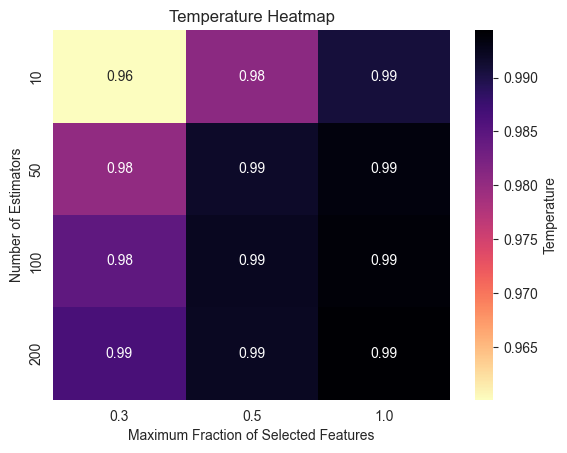

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
bagging_data: DataFrame = result_tables["bagging"]
pivot_table = bagging_data.pivot(index='n_estimators', columns='max_features', values='mean_test_roc_auc_ovr')
# Set the column names as x-axis and the index as y-axis
sns.heatmap(pivot_table, annot=pivot_table, cmap='magma_r', cbar_kws={'label': 'Temperature'})
plt.title("Temperature Heatmap")
plt.ylabel("Number of Estimators")
plt.xlabel("Maximum Fraction of Selected Features")
plt.show()

In [55]:
result_tables["bagging"][result_tables["bagging"]["mean_test_roc_auc_ovr"] == result_tables["bagging"].mean_test_roc_auc_ovr.max()]

,max_features,n_estimators,mean_test_roc_auc_ovr
3,1.0,200,0.994407


In [56]:
result_tables["random_forrest"][result_tables["random_forrest"]["mean_test_roc_auc_ovr"] == result_tables["random_forrest"].mean_test_roc_auc_ovr.max()]

,class_weight,max_depth,min_samples_split,n_estimators,mean_test_roc_auc_ovr
30,balanced,20,5,200,0.995548


In [57]:
result_tables["decision_tree"][result_tables["decision_tree"]["mean_test_roc_auc_ovr"] == result_tables["decision_tree"].mean_test_roc_auc_ovr.max()]

,class_weight,criterion,max_depth,min_samples_leaf,mean_test_roc_auc_ovr
23,balanced,entropy,10,10,0.990117


In [58]:
result_tables["log_reg"][result_tables["log_reg"]["mean_test_roc_auc_ovr"] == result_tables["log_reg"].mean_test_roc_auc_ovr.max()]

,max_iter,mean_test_roc_auc_ovr
3,10000,0.983202


# Final Hyperparameter Combination for each of the trained Models

| Model Name | Max Fraction Selected Features | Number of Estimators | Mean ROC AUC Score (OvR method) |
|------------|:------------------------------:|:--------------------:|:-------------------------------:|
| Bagging    |              1.0               |         200          |             0.9944              |

<br>
<br>

| Model Name    | Max Depth | Min Sample Split | Number of Estimators | Mean ROC AUC Score (OvR method) |
|---------------|:---------:|:----------------:|:--------------------:|:-------------------------------:|
| Random Forest |    20     |        5         |         200          |             0.9955              |

<br>
<br>

| Model Name    | Max Depth | Min Sample Leaf | Criterion | Mean ROC AUC Score (OvR method) |
|---------------|:---------:|:---------------:|:---------:|:-------------------------------:|
| Decision Tree |    10     |       10        |  entropy  |             0.9901              |

<br>
<br>

| Model Name          | Num Iterations | Mean ROC AUC Score (OvR method) |
|---------------------|:--------------:|:-------------------------------:|
| Logistic Regression |     10000      |             0.9832              |

# Discussion about Model Hyperparameter Selection:

It becomes visible that for Random Forests as well as XG-Boos Classification, the mean ROC AUC Scores are independent of the hyperparameters that where chosen
very good.
e.g.
A Random Forrest with 300 Estimators performs only 0.xxx better than the same forrest with only 50 estimators. Same counts for the XG-Boost Classifier.
Thus, it is arguable to consider to take one of the smaller models since it seems that it does not have a huge effect on the overall performance.

However, those are only the risk estimates from the Cross Validation. Testing all hyperparameter combinations on the test data to see which combination performs best would violate the model selection protocol in terms of obtaining a pessimistic estimator.


# Save the Test Data and Cross Validation Data to use in the final model Evaluation

In [59]:
save_path_cross_val_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\cross_validation_data.csv"
save_path_test_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\test_data.csv"

cross_validation_data = pd.concat((x_train, y_train), axis=1)
test_data = pd.concat((x_test, y_test), axis=1)
cross_validation_data.to_csv(save_path_cross_val_data)
test_data.to_csv(save_path_test_data)